In [2]:
import os
import os.path as osp

import random


import numpy as np
import open3d as o3d
import cv2

import utils

from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
pcd_path = "data/kinth/pointcloud/1720509720.141261339.pcd"
pcd = o3d.io.read_point_cloud(pcd_path)
# pcd = pcd.voxel_down_sample(voxel_size=0.01)
pcd = pcd.remove_radius_outlier(nb_points=25, radius=0.2)[0] # (pcd, new indexed from old)

points = np.asarray(pcd.points)
points = points - points.mean(axis=0)
print("max, min:", points.max(axis=0), points.min(axis=0))
print(f"before voxelized: {len(points)}")
points, _, _, _ = utils.voxel_downsample(points, 0.02, use_avg=False)
print("max, min:", points.max(axis=0), points.min(axis=0))
print(f"after voxelized: {len(points)}")

max, min: [4.71142875 3.22041954 1.96897121] [-3.35557116 -4.00158058 -1.04102878]
before voxelized: 12234
max, min: [8.07 7.23 3.01] [0.01 0.01 0.01]
after voxelized: 7677


# stage 1

In [4]:
radius = 0.15

colors = np.ones((len(points), 3), dtype=np.int32) * 75

stage1_feat_list = []
search_tree = o3d.geometry.KDTreeFlann(utils.npy2o3d(points))
for query_idx in tqdm(range(len(points)), total=len(points), ncols=100):
    query = points[query_idx]
    neighbour_num, neighbour_idx_list, _ = search_tree.search_radius_vector_3d(query, radius)
    if neighbour_num <= 3:
        stage1_feat_list.append([0.0, 0.0])
        continue
    eigvals, eigvecs = utils.pca_k(points[neighbour_idx_list], 3)
    assert eigvals[0] >= eigvals[1] and eigvals[1] >= eigvals[2]
    feat = np.array([
        (eigvals[0] - eigvals[1]) / (eigvals[0] + 1e-9),
        (eigvals[1] - eigvals[2]) / (eigvals[1] + 1e-9)
    ])
    feat = feat / feat.sum()
    stage1_feat_list.append(feat)
    
    colors[query_idx, :2] = (feat * 255.0).astype(np.int32)

utils.npy2ply(points, colors, "data/output/stage1.ply")

stage1_feat_list = np.array(stage1_feat_list)

 18%|██████████▏                                             | 1396/7677 [00:00<00:00, 13957.92it/s]

100%|████████████████████████████████████████████████████████| 7677/7677 [00:00<00:00, 15515.20it/s]


# stage 2

In [5]:
wup = np.array([0, 0, 1])
border = 0.4
colors = np.ones((len(points), 3), dtype=np.int32) * 50

stage2_feat_list = []

for query_idx in tqdm(range(len(points)), total=len(points), ncols=100):
    query = points[query_idx]
    mask = (
        (np.abs(points[:, 0] - query[0]) < border / 2.0) &
        (np.abs(points[:, 1] - query[1]) < border / 2.0) &
        (np.abs(points[:, 2] - query[2]) < border)
    )
    mask[query_idx] = False
    vicinity = points[mask]
    if len(vicinity) < 3:
        stage2_feat_list.append(0.0)
        continue
    feat = (1.0 - utils.sin_batch(points[mask] - query, wup)).mean()
    stage2_feat_list.append(feat)
    
    colors[query_idx] = int(feat * 255.0)

utils.npy2ply(points, colors, "data/output/stage2.ply")

stage2_feat_list = np.array(stage2_feat_list)

100%|████████████████████████████████████████████████████████| 7677/7677 [00:00<00:00, 11654.64it/s]


# filter

In [6]:
mask1 = (stage1_feat_list[:, 1] > 0.7)
mask2 = (stage2_feat_list > 0.3)

mask_filtered = mask1 & mask2
print(mask1.astype(np.int32).sum() / len(points))
print(mask2.astype(np.int32).sum() / len(points))
print(mask_filtered.astype(np.int32).sum() / len(points))

points_filtered = points[mask_filtered]
utils.npy2ply(points_filtered, None, "data/output/filtered.ply")

mask_denoised = utils.radius_filter(points_filtered, 0.2, 20)
points_denoised = points_filtered[mask_denoised] 
utils.npy2ply(points_denoised, None, "data/output/denoised.ply")


0.3016803438843298
0.5642829230168034
0.21101992966002345


# cluster

In [7]:
cluster_label = np.array(utils.npy2o3d(points_denoised).cluster_dbscan(eps=0.15, min_points=20))

In [8]:
print(np.unique(cluster_label))
# do the color map
norm = plt.Normalize(cluster_label.min(), cluster_label.max())
cmap = matplotlib.colormaps['viridis']
colors = (cmap(norm(cluster_label))[:, :3] * 255.0).astype(np.int32)
print(colors)
utils.npy2ply(points_denoised, colors, "data/output/clustered.ply")

[-1  0  1  2  3  4]
[[ 64  67 135]
 [ 64  67 135]
 [ 64  67 135]
 ...
 [ 41 120 142]
 [ 41 120 142]
 [ 41 120 142]]


# single cluster bounding box

In [9]:
aabb = utils.npy2o3d(points_denoised[cluster_label == 0]).get_axis_aligned_bounding_box()
aabb_minmax = np.concatenate([aabb.min_bound.reshape(-1, 1), aabb.max_bound.reshape(-1, 1)], axis=1)
# generate all verteices for bounding box
aabb_vtx_list = []
for i in range(8):
    vtx_idx = [int(x) for x in bin(i)[2:].zfill(3)]
    aabb_vtx_list.append([
        aabb_minmax[0][vtx_idx[0]],
        aabb_minmax[1][vtx_idx[1]],
        aabb_minmax[2][vtx_idx[2]]
    ])

aabb_vtx_list = np.array(aabb_vtx_list)

In [10]:
bbox_proj_3d, bbox_3d_dist = utils.project_to_plane(aabb_vtx_list, np.array([1, 2, 3]), np.array([0, 0, 1]))
bbox_proj_2d_densit, bbox_proj_2d_height, bbox_proj_grid_index = utils.rasterize(bbox_proj_3d, bbox_3d_dist, 0.01)
print(bbox_proj_grid_index)
bbox_img = cv2.cvtColor((bbox_proj_2d_densit * 255.0).astype(np.uint8), cv2.COLOR_GRAY2BGR)
for i in range(len(bbox_proj_grid_index)):
    p1 = bbox_proj_grid_index[i][::-1]
    p2 = bbox_proj_grid_index[(i+1)%len(bbox_proj_grid_index)][::-1]
    cv2.line(bbox_img, p1, p2, (0, 255, 0), 1)
cv2.imwrite("data/output/bbox_test.png", bbox_img)

[[16 22]
 [16  0]
 [ 0 48]
 [ 0 25]
 [23 25]
 [23  2]
 [ 7 51]
 [ 7 28]]


/home/hm/fuguiduo/workspace/tmp/lasvisual/utils/tools.py:396: RuntimeWarning: invalid value encountered in divide
  image_height = image_height / image_densit


True

# multicluster projection

(370, 394, 3)


/home/hm/fuguiduo/workspace/tmp/lasvisual/utils/tools.py:396: RuntimeWarning: invalid value encountered in divide
  image_height = image_height / image_densit


True

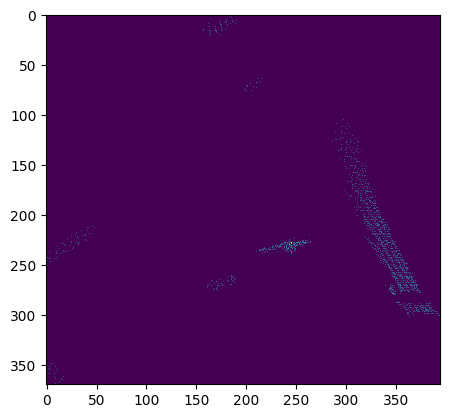

In [39]:
cluster_label = np.array(utils.npy2o3d(points_denoised).cluster_dbscan(eps=0.15, min_points=20))

proj_3d, dist_3d = utils.project_to_plane(
    points_denoised,
    np.array([1, 2, 3]),
    np.array([0, 0, 1])
)

proj_2d_densit, proj_2d_height, grid_idx_list = utils.rasterize(
    proj_3d, dist_3d, 0.01
)

plt.imshow(proj_2d_densit)

# prepare for color mapping
norm = plt.Normalize(cluster_label.min(), cluster_label.max())
cmap = matplotlib.colormaps['viridis']
colors = (cmap(norm(cluster_label))[:, :3] * 255.0).astype(np.uint8)
result_img = cv2.cvtColor((proj_2d_densit * 255.0).astype(np.uint8), cv2.COLOR_GRAY2BGR)
print(result_img.shape)
for idx, coord in enumerate(grid_idx_list):
    result_img[coord[0], coord[1]] = colors[idx]
cv2.imwrite("data/output/cluster_proj.png", result_img)